In [1]:
import torch
from torch.utils.data import DataLoader
import albumentations as A
from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.utils import count_parameters
from levee_hunter.plots import infer_and_visualize
import numpy as np
import segmentation_models_pytorch as smp

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/../..

In [2]:
# Load the datasets
good_dataset = torch.load("../data/processed/w1-2-based-datasets/good_dataset_256_nooverlap.pth")
bad_dataset = torch.load("../data/processed/w1-2-based-datasets/bad_dataset_256_nooverlap.pth")

# Verify the data loaded correctly
print(len(good_dataset))  
print(len(bad_dataset))   

/var/folders/tk/2_f29kq533g52jyhs9y4xt000000gn/T/ipykernel_3500/3725858683.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  good_dataset = torch.load("../data/processed/w

1584
1584


In [3]:
# Removing empty images (where target does not contain levee)
good_dataset.remove_empty(keep_empty=0.2)
bad_dataset.remove_empty(keep_empty=0.0)

In [4]:
len(good_dataset.images), len(bad_dataset.images)

(340, 123)

In [5]:
# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.VerticalFlip(p=0.5),    # Random vertical flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),  # Small shifts, scaling, rotation
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastic deformation
    A.Normalize(mean=0.0, std=1.0),  # Normalize to 0 mean and 1 std
])

normalize_only = A.Compose([
    A.Normalize(mean=0.0, std=1.0),  # Normalize to 0 mean and 1 std
])

/var/folders/tk/2_f29kq533g52jyhs9y4xt000000gn/T/ipykernel_3500/4123746944.py:7: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastic deformation


In [6]:
# Set transforms, for training use augmentations, for testing just normalize
good_dataset.transform = train_transform
bad_dataset.transform = normalize_only

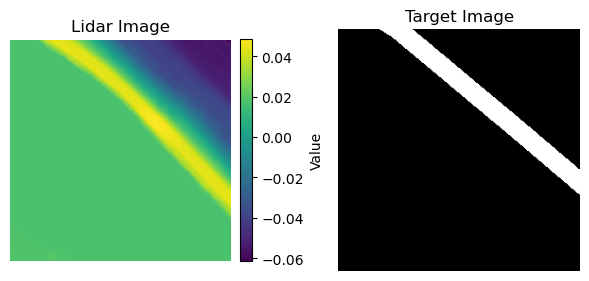

In [7]:
good_dataset.plot(10, transform=True)

The idea is that good_dataset contains images made out of those original (3000, 3000) images which appeared to not have any levees missing.
bad_dataset is made out of those that did have some levees missing.

Then self.remove_empty(keep_empty=0.2) is used to select only those images in dataset which have a target image with levee on it (levee pixels are masked with 0 so if there is 0 anywhere on the target image, this means it has a levee on it). keep_empty is used to then add a fraction of those images which did not have any levee on target image, eg 0.2 means that for 100 non empty images, 20 empty ones are added. This procedure redefines self.images as having mostly non empty images, and some smaller portion of empty images. For good_dataset there is no risk of having levee on Lidar image while having empty target image, because as mentioned earlier good_dataset is made out of those pictures which did not have missing levees. For bad_images this risk is not eliminated so far and that is why this dataset is named bad_dataset. 

The good_dataset is ready to be used for training at this point. Some fraction of it could be used for validation, but I decided to use bad_dataset instead, choosing a few images by eye and checking if they do not have missing levees.

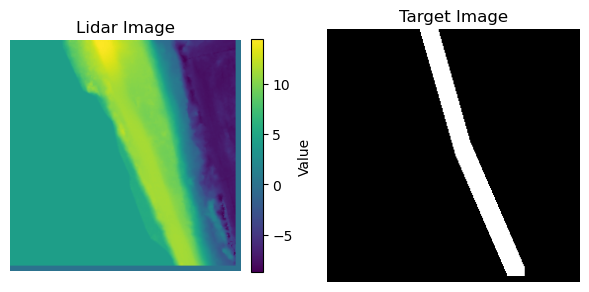

In [8]:
bad_dataset.plot(idx=122)

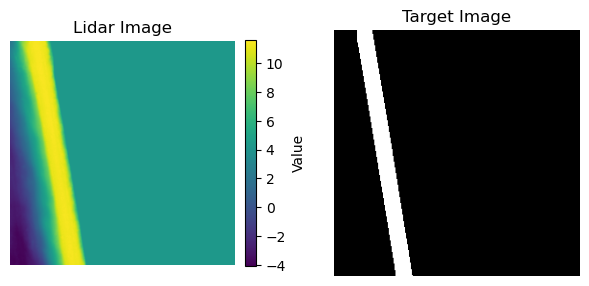

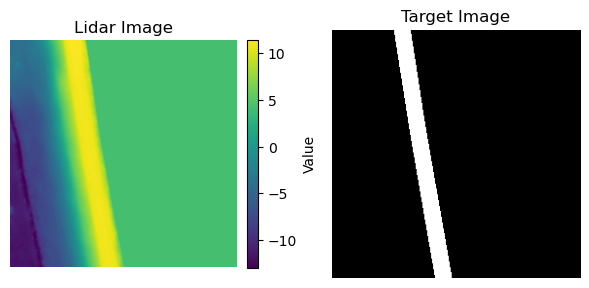

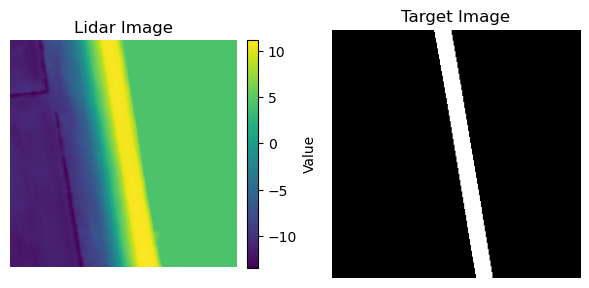

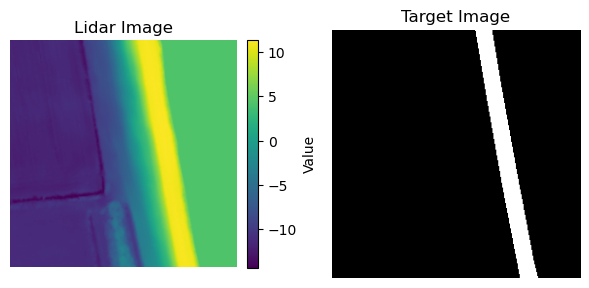

In [9]:
for ix in range(4):
    bad_dataset.plot(ix, transform=False)

In [10]:
# Selected images which are challenging, for by eye validaion only
# Eg three of them have missing levees
by_eye_val_images = np.array(bad_dataset.images)[[49, 53, 85, 4, 11, 26, 52, 58, 70, 79, 106, 110, 121]]
by_eye_val_targets = np.array(bad_dataset.targets)[[49, 53, 85, 4, 11, 26, 52, 58, 70, 79, 106, 110, 121]]
by_eye_val_images.shape

(13, 1, 256, 256)

In [11]:
# Create a dataset
val_by_eye_dataset = SegmentationDataset(images=by_eye_val_images, targets=by_eye_val_targets, transform=normalize_only, patch_size=256, final_size=256, overlap=0)

In [12]:
# Remove three images with missing levees
good_for_val_images = np.delete(np.array(bad_dataset.images), [49, 53, 85], axis=0)
good_for_val_targets = np.delete(np.array(bad_dataset.targets), [49, 53, 85], axis=0)
good_for_val_images.shape

(120, 1, 256, 256)

In [13]:
# Now lets take a few empty images and add them to validation dataset
# We take those from the good dataset, so that there is no risk of
# accidentally having a levee on Lidar image and not on target
empty_images = np.array(good_dataset.empty_images)[:20]
empty_targets = np.array(good_dataset.empty_targets)[:20]
empty_images.shape, empty_targets.shape

((20, 1, 256, 256), (20, 1, 256, 256))

In [14]:
val_dataset = SegmentationDataset(images=np.concatenate([good_for_val_images, empty_images]).squeeze(), 
                                  targets=np.concatenate([good_for_val_targets, empty_targets]).squeeze(),
                                  transform = normalize_only, split=False)

In [15]:
val_dataset.images[0].shape

(256, 256)

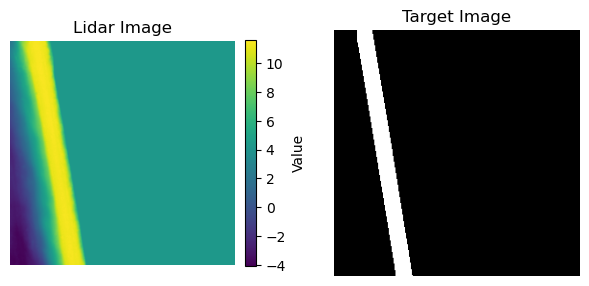

In [16]:
bad_dataset.plot(0)

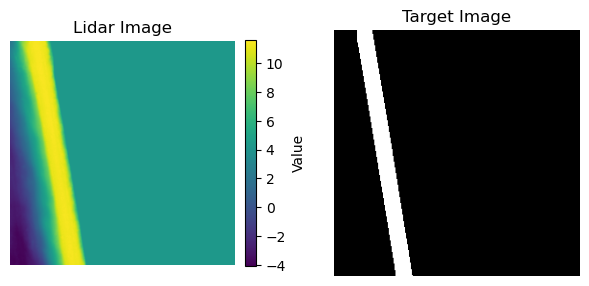

In [17]:
val_dataset.plot(0)

# Data Loader and Batch Size

In [18]:
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(good_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [19]:
train_loader.dataset.images[0].shape

torch.Size([1, 256, 256])

# Model

In [20]:
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=1, classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
best_loss = float('inf')
epochs = 17

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, mask in train_loader:
        images, mask = images.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, mask in val_loader:
            images, mask = images.to(device), mask.to(device)
            output = model(images)
            loss = criterion(output, mask)
            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} Train Loss: {train_loss} Val Loss: {val_loss}")

Epoch: 1/17 Train Loss: 0.5726061680100181 Val Loss: 0.6944240927696228
Epoch: 2/17 Train Loss: 0.3346841606226834 Val Loss: 0.5028999447822571
Epoch: 3/17 Train Loss: 0.24088728427886963 Val Loss: 0.4672478139400482
Epoch: 4/17 Train Loss: 0.18701764805750412 Val Loss: 0.25353044271469116
Epoch: 5/17 Train Loss: 0.15641751479018817 Val Loss: 0.20728997886180878
Epoch: 6/17 Train Loss: 0.134977441619743 Val Loss: 0.19436746835708618
Epoch: 7/17 Train Loss: 0.1213728819381107 Val Loss: 0.14074097573757172
Epoch: 8/17 Train Loss: 0.11954798955808986 Val Loss: 0.1326802670955658
Epoch: 9/17 Train Loss: 0.11073327877304771 Val Loss: 0.1774255931377411
Epoch: 10/17 Train Loss: 0.10262635959820314 Val Loss: 0.13483519852161407
Epoch: 11/17 Train Loss: 0.10060306841676886 Val Loss: 0.1203090101480484
Epoch: 12/17 Train Loss: 0.10142683779651468 Val Loss: 0.12738783657550812
Epoch: 13/17 Train Loss: 0.09532570906660774 Val Loss: 0.13984230160713196
Epoch: 14/17 Train Loss: 0.09911465780301527 

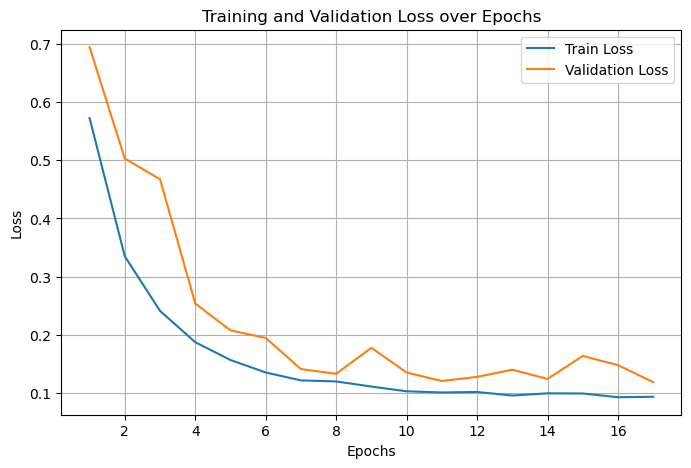

In [22]:
# Plot training and validation loss
epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss_list, label="Train Loss")
plt.plot(epochs_range, val_loss_list, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
torch.save(model.state_dict(), "../models/w1-2-based-model/unet-model.pth")

print("Saved model at ../models/w1-2-based-model/unet-model.pth")

Saved model at ../models/w1-2-based-model/unet-model.pth


In [24]:
count_parameters(model)

24430097

0


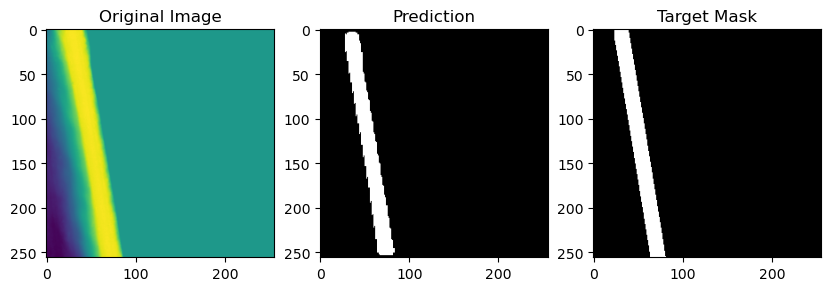

1


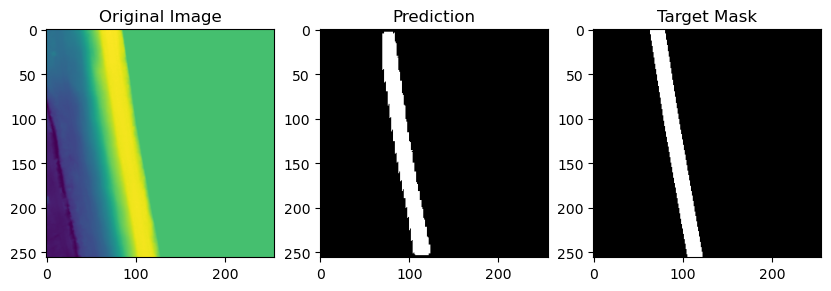

2


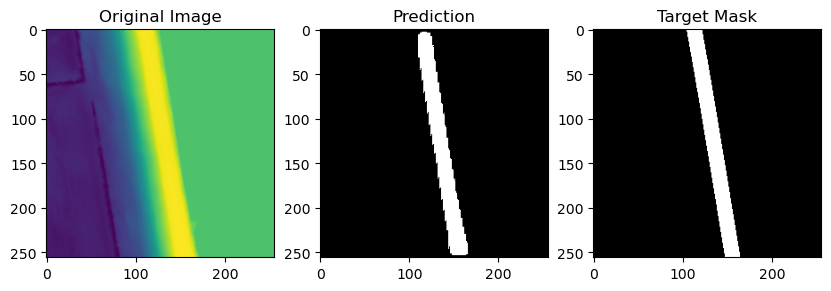

3


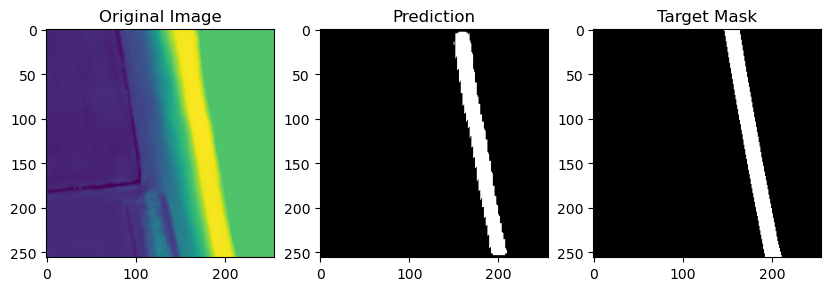

4


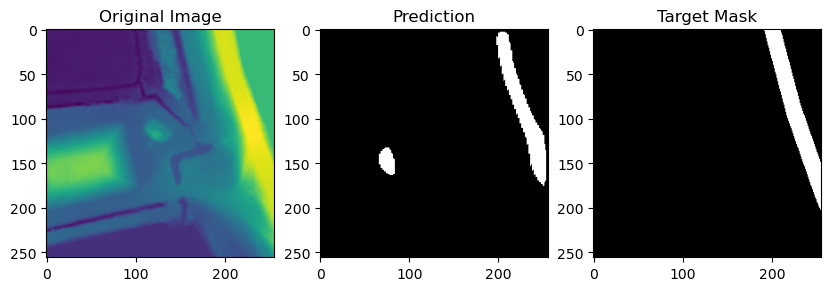

5


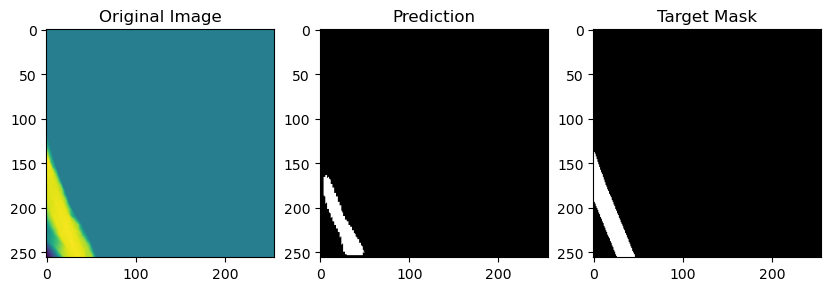

6


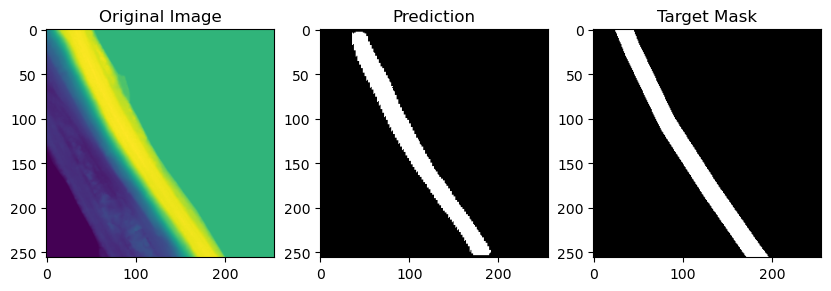

7


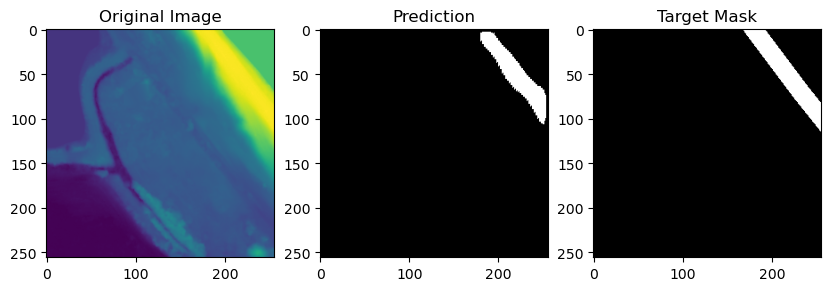

8


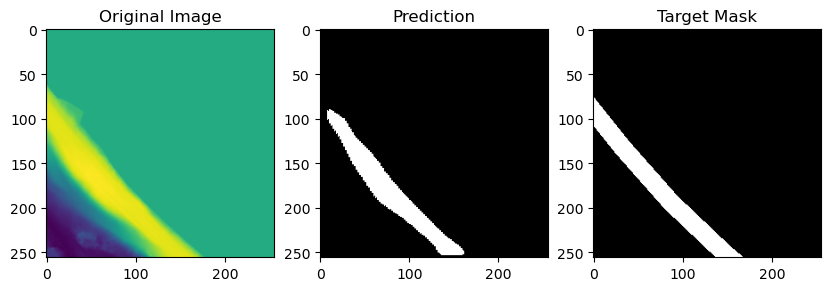

9


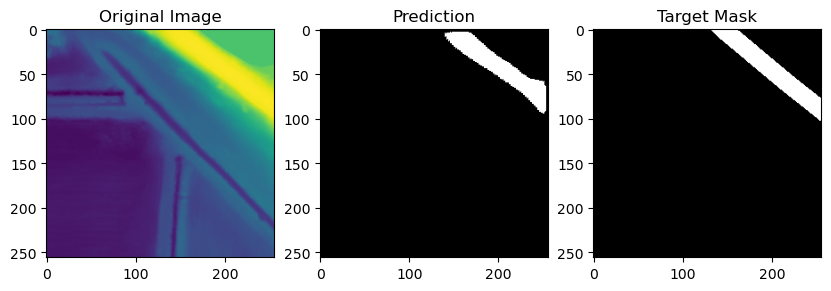

10


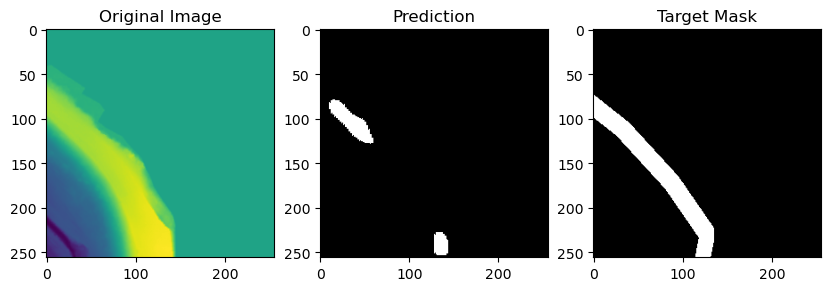

11


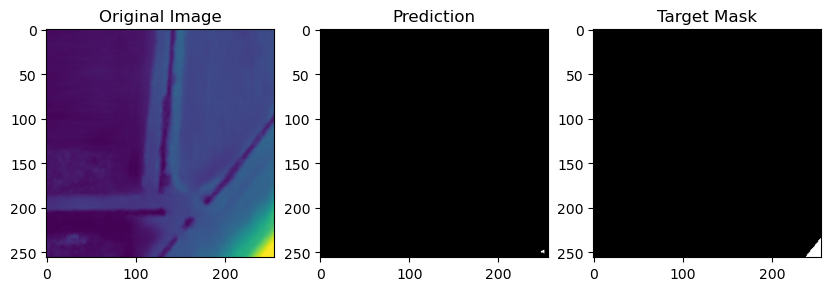

12


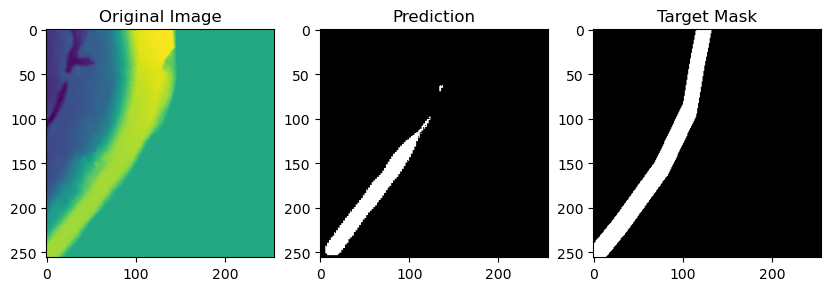

13


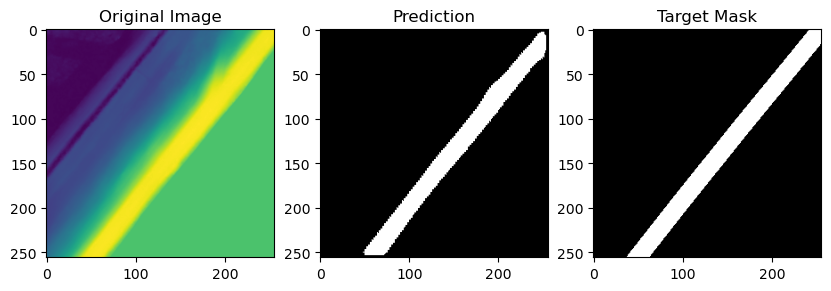

14


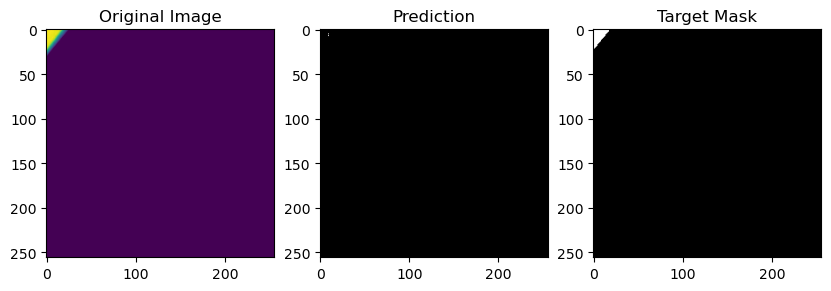

15


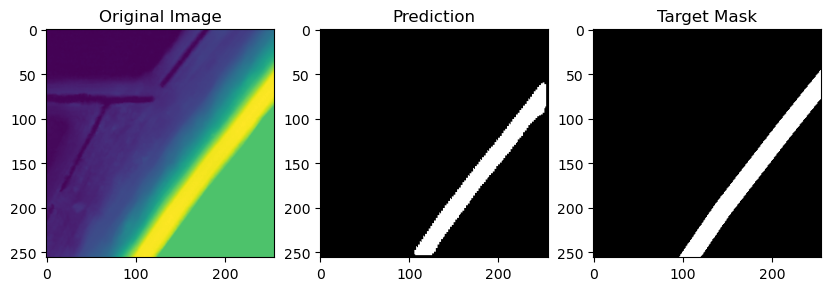

16


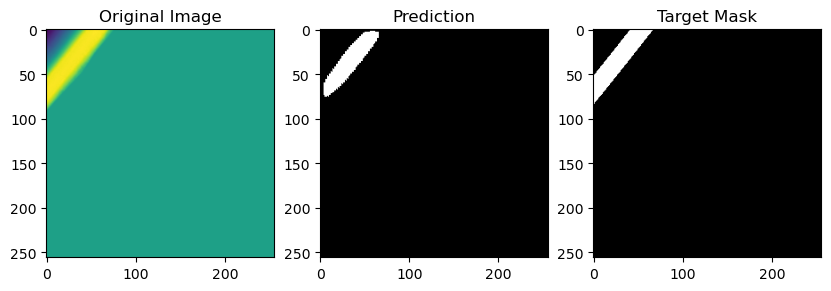

17


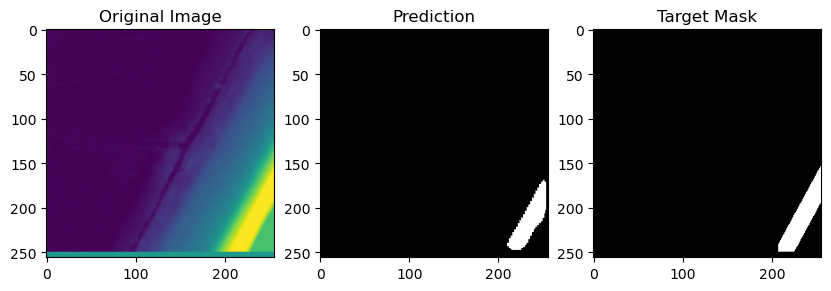

18


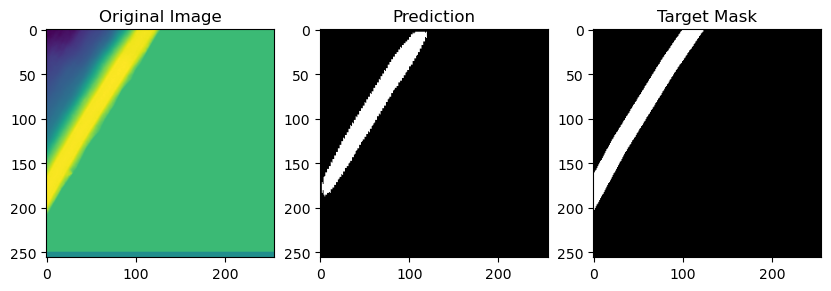

19


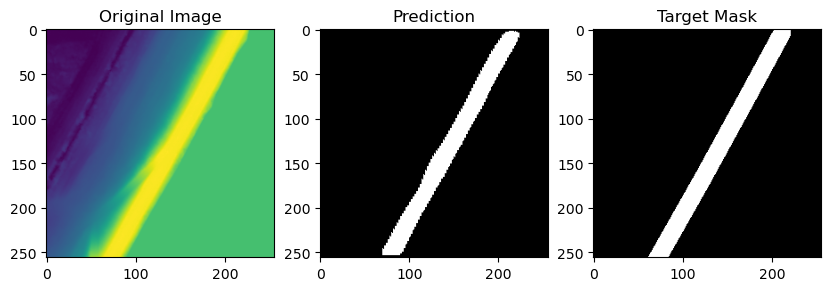

20


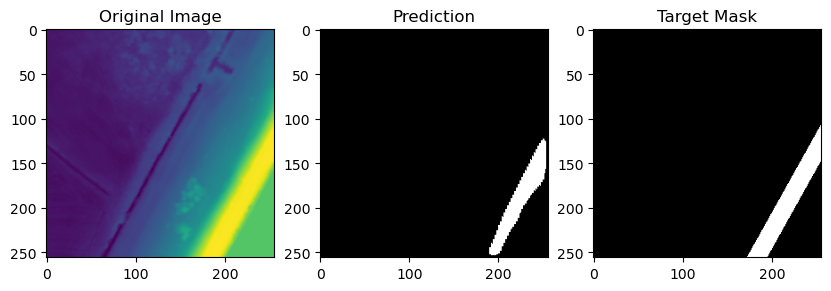

21


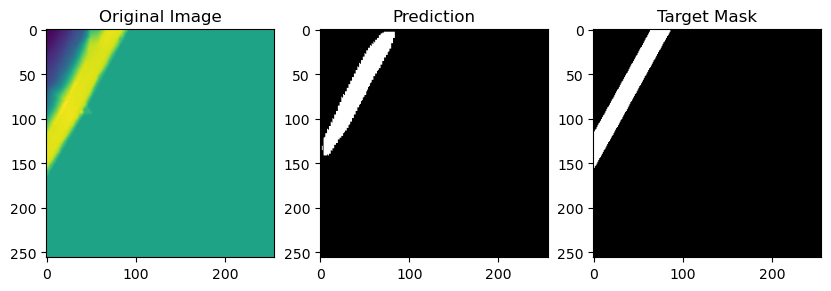

22


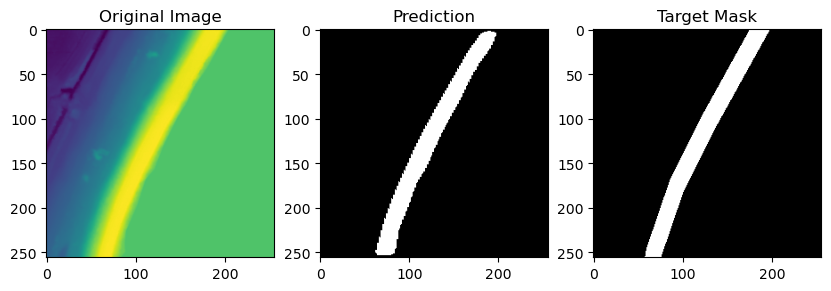

23


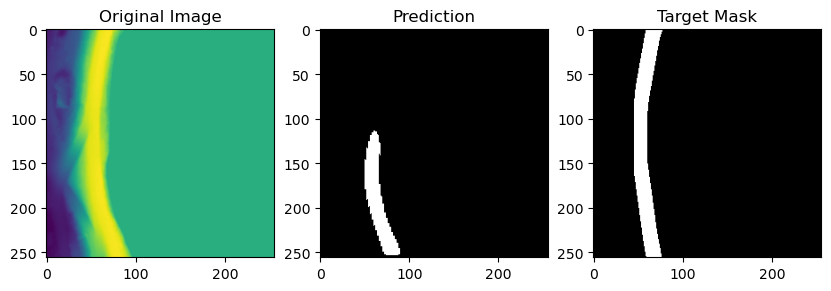

24


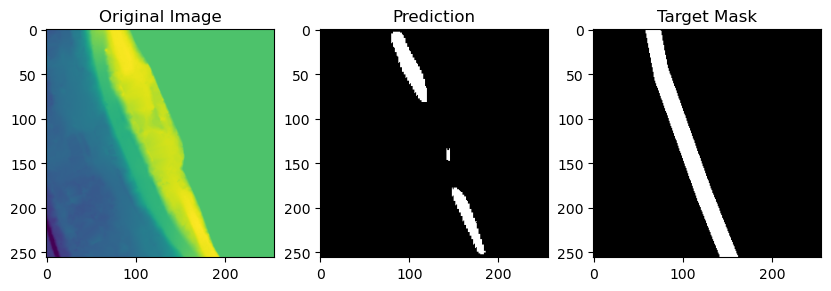

25


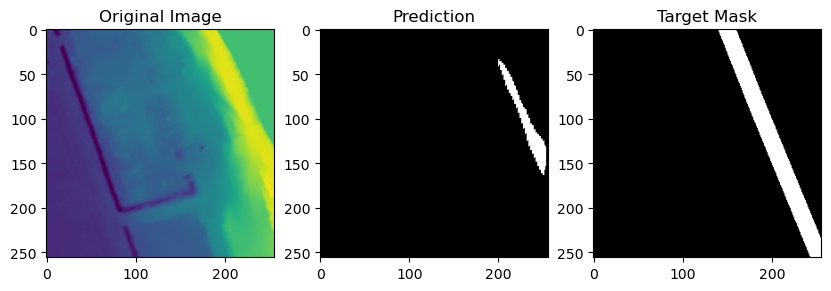

26


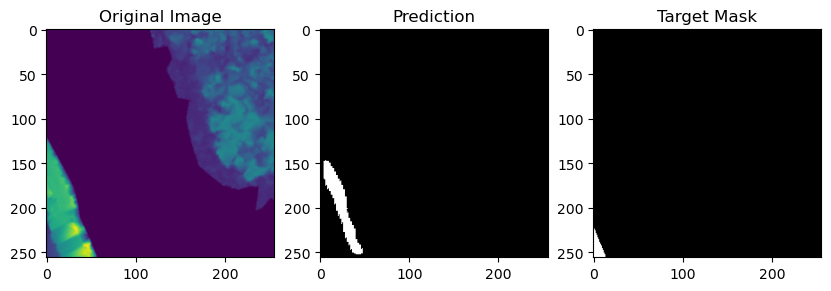

27


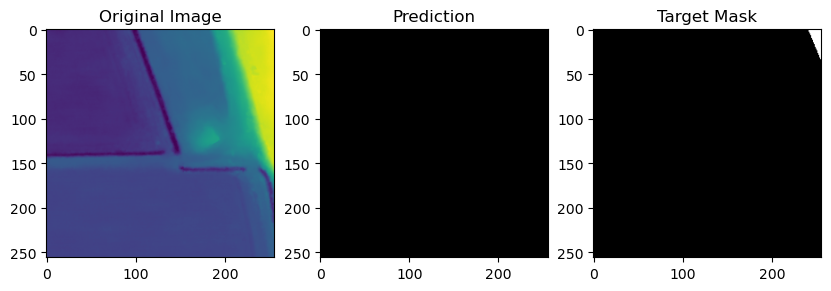

28


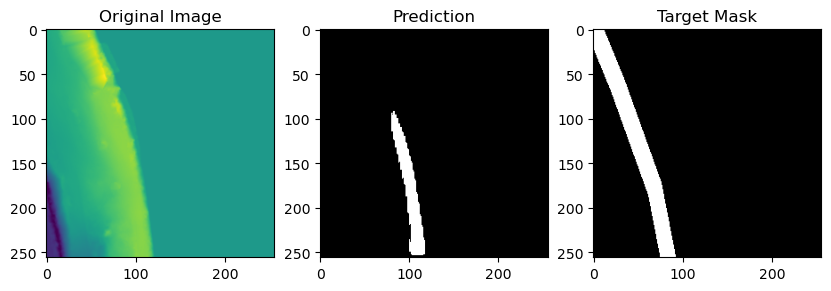

29


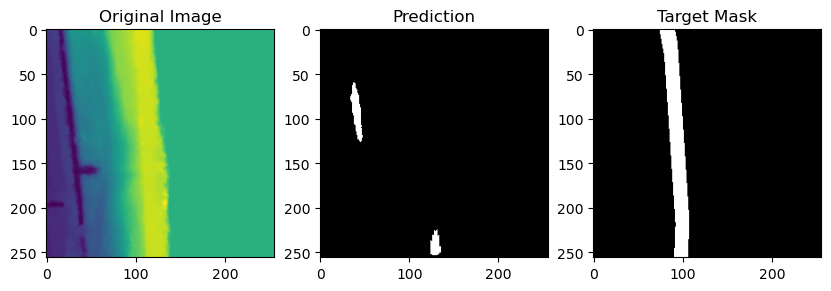

In [25]:
val_dataset.transform = normalize_only
for ix in range(30):
    sample_image, sample_mask = val_dataset[ix]
    #sample_image = sample_image.unsqueeze(0)
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True)